In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score
)

from xgboost import XGBClassifier

In [11]:
def load_data(filepath=r'C:\Users\Bhuwan\Desktop\dimentia\final_dementia_dataset.csv'):
    """Loads the final cleaned dementia dataset."""
    try:
        df = pd.read_csv(filepath)
        print(f"Successfully loaded '{filepath}'.")
        return df

    except FileNotFoundError:
        print(f"Error: '{filepath}' not found.")
        print("Please run the data cleaning pipeline to generate 'final_dementia_dataset.csv'.")
        return None


In [20]:
from sklearn.preprocessing import StandardScaler

def preprocess_data(df):
    """Splits and scales the data for training and testing (CDR retained)."""

    # Separate features and target
    X = df.drop(['Dementia', 'CDR'], axis=1)
   # CDR is NOT dropped
    y = df['Dementia']
    feature_names = X.columns.tolist()


    # Train-test split (85% train, 15% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.15,
        random_state=42,
        stratify=y
    )

    # Feature scaling (optional for XGBoost, required for SVM/LogReg)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print("Data successfully split and scaled (CDR retained).")

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, feature_names

In [13]:
def train_and_evaluate(X_train, y_train, X_test, y_test):

    from xgboost import XGBClassifier
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import (
        accuracy_score,
        classification_report,
        confusion_matrix
    )
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    # -----------------------------
    # HANDLE CLASS IMBALANCE
    # -----------------------------
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    # PARAMETER GRID
    param_grid = {
        "n_estimators": [100, 200],
        "max_depth": [3, 4, 5],
        "learning_rate": [0.01, 0.05, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    }

    xgb = XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        eval_metric="logloss",
        random_state=42
    )

    # -----------------------------
    # GRID SEARCH
    # -----------------------------
    print("Starting hyperparameter tuning for XGBoost with GridSearchCV...")

    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        cv=5,
        scoring="recall",   # IMPORTANT for dementia detection
        n_jobs=-1,
        verbose=2
    )

    grid_search.fit(X_train, y_train)

    print("\nHyperparameter tuning complete.")
    print("Best parameters found:", grid_search.best_params_)

    best_model = grid_search.best_estimator_


    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    print("\n--- Model Evaluation (Best XGBoost Model) ---")
    print(f"Accuracy: {accuracy:.4f}\n")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Nondemented", "Demented"],
        yticklabels=["Nondemented", "Demented"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix (Best XGBoost Model)")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    plt.show()

    print("\nConfusion matrix saved as 'confusion_matrix.png'")

    return best_model



In [14]:
def save_artifacts(model, scaler, feature_names):
    """Saves the trained model, scaler, and feature names to disk."""
    
    import joblib

    joblib.dump(model, "dementia_model.pkl")
    joblib.dump(scaler, "scaler.pkl")
    joblib.dump(feature_names, "feature_names.pkl")

    print("✅ Model, scaler, and feature names saved successfully!")
    print("📁 Files created:")
    print("   - dementia_model.pkl")
    print("   - scaler.pkl")
    print("   - feature_names.pkl")
    print("\n➡️ You can now run '3_questionnaire.py' to make predictions.")


In [15]:
def main():
    """Main function to orchestrate the model training pipeline."""

    # Load data
    df = load_data()
    if df is None:
        print("❌ Data loading failed. Exiting pipeline.")
        return

    # Preprocess data
    X_train, X_test, y_train, y_test, scaler, features = preprocess_data(df)

    # Train and evaluate model
    model = train_and_evaluate(X_train, y_train, X_test, y_test)

    # Save model artifacts
    save_artifacts(model, scaler, features)

    print("\n🎉 Model training pipeline completed successfully!")



Successfully loaded 'C:\Users\Bhuwan\Desktop\dimentia\final_dementia_dataset.csv'.
Data successfully split and scaled (CDR retained).
Starting hyperparameter tuning for XGBoost with GridSearchCV...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Hyperparameter tuning complete.
Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 1.0}

--- Model Evaluation (Best XGBoost Model) ---
Accuracy: 0.7879

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.75      0.81        20
           1       0.69      0.85      0.76        13

    accuracy                           0.79        33
   macro avg       0.78      0.80      0.78        33
weighted avg       0.81      0.79      0.79        33



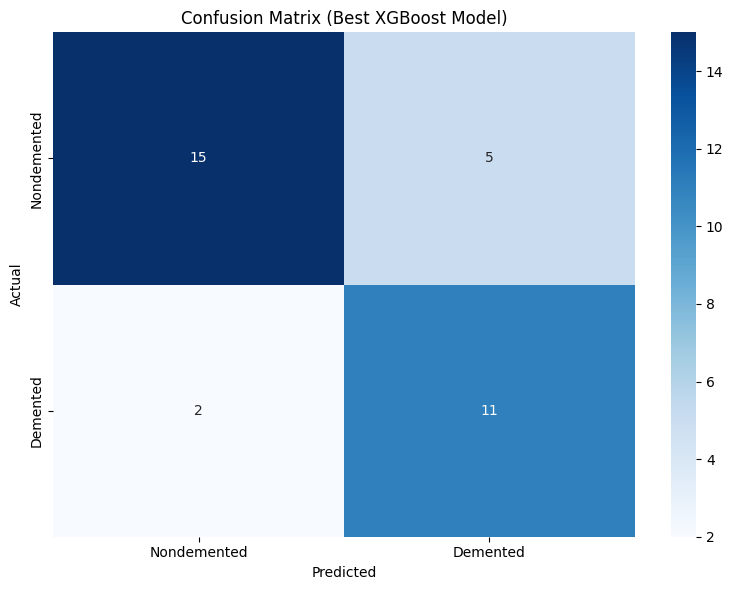


Confusion matrix saved as 'confusion_matrix.png'
✅ Model, scaler, and feature names saved successfully!
📁 Files created:
   - dementia_model.pkl
   - scaler.pkl
   - feature_names.pkl

➡️ You can now run '3_questionnaire.py' to make predictions.

🎉 Model training pipeline completed successfully!


In [21]:
if __name__ == '__main__':
    main()